# PUNTO 2.

Se estudian distintos tipos de modelos no lineales para ajustar el precio del Bitcoin y determinar futuros valores. 

(1) El primer modelo a estudiar es un modelo cuadrático. Si $y_i$ corresponde al precio del Bitcoin en el $i$-ésimo día, se va a encontrar el valor de los coeficientes del polinomio $p(x)=ax^2+bx+c$ tal que $p(i)$ se aproxime al valor $y_i$ bajo la perspectiva de mínimos cuadrados.

Lo primero es seleccionar un conjunto de datos. Este conjunto contiene los valores del Bitcoin en dólares correspondientes al último mes (desde el 15 de Febrero hasta el 15 de Marzo de 2022). Dado que es un archivo .csv es buena idea leerlo utilizando el paquete DelimitedFiles

In [2]:
using DelimitedFiles

P,H = readdlm("BitcoinHistorical.csv", ',', header=true)

(Any["Mar 15, 2022" "39,095.0" … "2.24B" "-1.45%"; "Mar 14, 2022" "39,671.1" … "2.33B" "4.97%"; … ; "Feb 16, 2022" "43,883.6" … "41.40K" "-1.48%"; "Feb 15, 2022" "44,544.4" … "56.34K" "4.69%"], AbstractString["\ufeff\"Date\"" "Price" … "Vol." "Change %"])

Dado que el archivo .csv contiene distintos parámetros correspondientes al precio del Bitcoin (como precio, tasa de cambio, valor de apertura y de cierre) se selecciona la columna que contiene los datos de interes y se organizan en formato float y en orden ascendente de tiempo para facilitar su uso.

In [3]:
using DataFrames
df = DataFrame(date = P[:,1], price = P[:,2]);
df[:,2] = replace.(df[:,2], "," => "");
df[:,2] = parse.(Float64, df[:,2]);
sort!(df);

A continuación se define la matriz A y el vector b correspondientes al problema planteado. Bajo la perspectiva de los mínimos cuadrados, se espera encontrar el valor de $x=[a,b,c]$ tal que $||Ax-b||_2^2$ sea mínimo.

In [26]:
b = Array(df[:,2]);
A = [map(x -> x^2, Array((1:29))) Array((1:29)) ones(29,1)];
println(A)
println(b)

[1.0 1.0 1.0; 4.0 2.0 1.0; 9.0 3.0 1.0; 16.0 4.0 1.0; 25.0 5.0 1.0; 36.0 6.0 1.0; 49.0 7.0 1.0; 64.0 8.0 1.0; 81.0 9.0 1.0; 100.0 10.0 1.0; 121.0 11.0 1.0; 144.0 12.0 1.0; 169.0 13.0 1.0; 196.0 14.0 1.0; 225.0 15.0 1.0; 256.0 16.0 1.0; 289.0 17.0 1.0; 324.0 18.0 1.0; 361.0 19.0 1.0; 400.0 20.0 1.0; 441.0 21.0 1.0; 484.0 22.0 1.0; 529.0 23.0 1.0; 576.0 24.0 1.0; 625.0 25.0 1.0; 676.0 26.0 1.0; 729.0 27.0 1.0; 784.0 28.0 1.0; 841.0 29.0 1.0]
Any[44544.4, 43883.6, 40552.8, 40000.1, 40090.3, 38355.0, 37017.7, 38248.2, 37224.6, 38339.2, 39209.6, 39115.5, 37689.1, 43188.2, 44420.3, 43912.8, 42463.0, 39142.7, 39395.8, 38403.1, 38024.8, 38744.8, 41929.0, 39416.3, 38730.2, 38814.3, 37792.4, 39671.1, 39095.0]


Finalmente, se utiliza el paquete LinearAlgebra para encontrar la inversa de Moore-Penrose de la matriz A, encontrar el valor del vector x, y solucionar el problema de minimización.

In [27]:
using LinearAlgebra

xh = pinv(A)*b

3-element Vector{Any}:
     2.8018035912921775
  -144.29346734466935
 41248.694088669974

A continuación se observa en azul la gráfica de los datos iniciales y en naranja la gráfica correspondiente al modelo cuadrático que mejor aproxima los datos

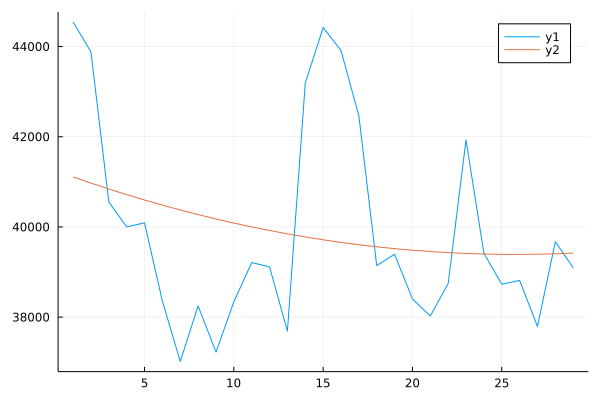

In [12]:
using Plots
pred = xh[1]*A[:,1] + xh[2]*A[:,2] + xh[3]*A[:,3]
plot(A[:,2],b)
plot!(A[:,2],pred)

Finalmente, se presentan los resultados obtenidos en la predicción del Bitcoin desde el 16 de Marzo hasta el 20 de Marzo. Se comparan con los precios que se observaron en esas fechas y se muestra el error porcentual que es, en promedio, 5%.

In [7]:
Preds = []
for i in 1:5
    append!(Preds,xh[1]*(29+i)^2 + xh[2]*(29+i) + xh[3])
end
Pt,Ht = readdlm("BitcoinToday.csv", ',', header=true);
dft = DataFrame(date = Pt[:,1], price = Pt[:,2]);
dft[:,2] = replace.(dft[:,2], "," => "");
dft[:,2] = parse.(Float64, dft[:,2]);
sort!(dft);
bt = Array(dft[:,2]);
dif = Preds-bt;
err = map(x -> abs(x),dif);
errpor = []
for i in 1:5
    append!(errpor, err[i]*100/bt[i])
end
DataFrame("Prediction" => Preds, "Bitcoin Price" => bt, "Difference" => dif, "Percent error" => errpor)

,Prediction,Bitcoin Price,Difference,Percent error
,Any,Any,Float64,Any
1,39441.5,41118.7,-1677.19,4.07889
2,39468.1,40914.8,-1446.67,3.53581
3,39500.4,41767.8,-2267.45,5.4287
4,39538.2,42233.0,-2694.83,6.38085
5,39581.6,41276.0,-1694.4,4.10505


(2) Al graficar los datos se observa que estos presentan oscilaciones notorias, por lo que se conjetura que un polinomio de grado mayor podría ajustar mejor los datos y, por tanto, realizar predicciones más exactas. Por esta razón, se estudia ahora un modelo polinomial de grado tres. Así, se desea encontrar el vector $x=[a,b,c,d]$ para hallar el polinomio $p(x)=ax^3+bx^2+cx+d$ que mejor se ajuste a los datos, bajo la perspectiva de los mínimos cuadrados.

In [9]:
A3 = [map(x -> x^3, Array((1:29))) map(x -> x^2, Array((1:29))) Array((1:29)) ones(29,1)];

Y se utiliza el paquete LinearAlgebra para hallar el vector $x$ que minimice el valor de $||A3x-b||_2^2$.

In [10]:
xh3 = pinv(A3)*b

4-element Vector{Any}:
    -2.1196219525322633
    98.18479145529957
 -1308.38984367607
 44402.69155403979

En la siguiente gráfica se observa en naranja el polinomio de grado 3 que mejor se ajusta a los datos

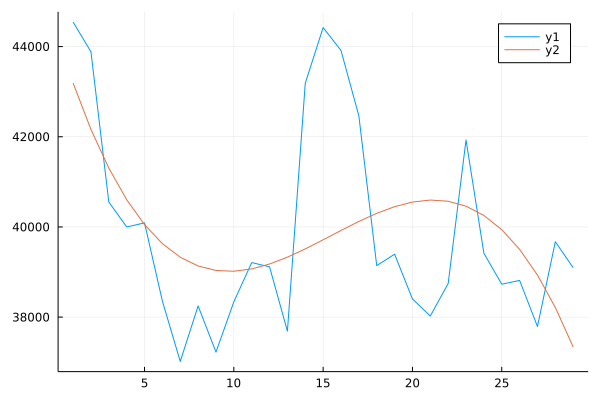

In [14]:
pred3 = xh3[1]*A3[:,1] + xh3[2]*A3[:,2] + xh3[3]*A3[:,3] + xh3[4]*A3[:,4]
plot(A3[:,3],b)
plot!(A3[:,3],pred3)

Finalmente, como en el caso del modelo cuadrático, se presenta una tabla con los datos de las predicciones y los valores presentados de los próximos 5 días (entre Marzo 16 y Marzo 20 del 2022).

In [17]:
Preds3 = []
for i in 1:5
    append!(Preds3,xh3[1]*(29+i)^3 + xh3[2]*(29+i)^2 + xh3[3]*(29+i) +xh3[4])
end
Pt,Ht = readdlm("BitcoinToday.csv", ',', header=true);
dft = DataFrame(date = Pt[:,1], price = Pt[:,2]);
dft[:,2] = replace.(dft[:,2], "," => "");
dft[:,2] = parse.(Float64, dft[:,2]);
sort!(dft);
bt = Array(dft[:,2]);
dif3 = Preds3-bt;
err3 = map(x -> abs(x),dif3);
errpor3 = []
for i in 1:5
    append!(errpor3, err3[i]*100/bt[i])
end
DataFrame("Prediction" => Preds3, "Bitcoin Price" => bt, "Difference" => dif3, "Percent error" => errpor3)

,Prediction,Bitcoin Price,Difference,Percent error
,Any,Any,Float64,Any
1,36287.5,41118.7,-4831.18,11.7494
2,35052.5,40914.8,-5862.27,14.328
3,33619.7,41767.8,-8148.13,19.5082
4,31976.2,42233.0,-10256.8,24.2862
5,30109.4,41276.0,-11166.6,27.0534


Se observa un mayor error porcentual, en comparación con el caso cuadrático, lo que indica que el modelo cuadrático es mejor.

(3) Finalmente, con el objetivo de encontrar una función que se ajuste mejor a los datos, se estudia un modelo polinomial de grado 11. Se desea encontrar el vector $x=[a_{11},a_{10},\cdots a_1, a_0]$ para hallar el polinomio $p(x)=a_{11}x^{11}+a_{10}x^{10}+\cdots +a_1x + a_0$ que mejor se ajuste a los datos, bajo la perspectiva de los mínimos cuadrados.

In [19]:
A11 = [map(x -> x^11, Array((1:29))) map(x -> x^10, Array((1:29))) map(x -> x^9, Array((1:29))) map(x -> x^8, Array((1:29))) map(x -> x^7, Array((1:29))) map(x -> x^6, Array((1:29))) map(x -> x^5, Array((1:29))) map(x -> x^4, Array((1:29))) map(x -> x^3, Array((1:29))) map(x -> x^2, Array((1:29))) Array((1:29)) ones(29,1)];
xh11 = pinv(A11)*b

12-element Vector{Any}:
   -3.9709747791508096e-7
    5.753937880106415e-5
   -0.0035113420529431397
    0.11676486276530314
   -2.2794614550466057
   26.016382073356777
 -159.01203229494885
  377.63420456186816
  228.83916933442134
   78.53708511905188
   21.47524686409519
    5.394052030666638

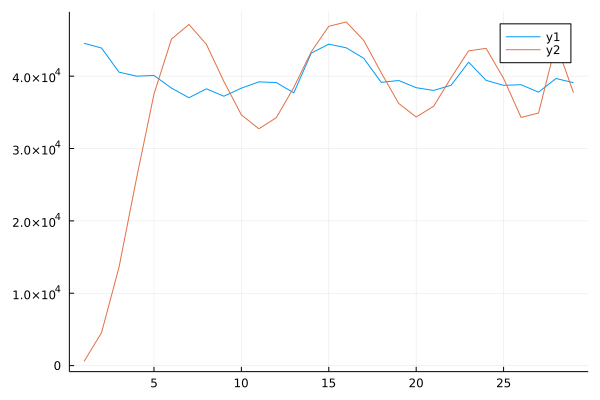

In [20]:
pred11 = zeros(29,1)
for i in 1:12
    pred11 = pred11 + xh11[i]*A11[:,i] 
end
plot(A11[:,11],b)
plot!(A11[:,11],pred11)

De la gráfica anterior se observa que el polinomio de grado 11 se ajusta bastante mejor a los datos que en los casos anteriores. Sin embargo, la predicción para el día 30 (es decir, para el día 16 de Marzo de 2022) es bastante inexacta. Se concluye que un modelo que gráficamente ajusta mejor los datos, no necesariamente realiza predicciones más exactas:

In [21]:
m = 0
for i in 1:12
    m = m + xh11[i]*30^(12-i)
end
print(m)

-92250.41057189378

(4) Finalmente, estudiamos un modelo sinusoidal. Deseamos encontrar los valores del vector $x=[a,b,c]$ tales que $f(x)=a\sin(x) + b\cos(x) +c$ se ajusten mejor al modelo bajo la perspectiva de los mínimos cuadrados.

In [23]:
As = [map(x -> sin(x), Array((1:29))) map(x -> cos(x), Array((1:29))) ones(29,1)];
xhs = pinv(As)*b

3-element Vector{Any}:
    81.07359459998383
  -754.4609809276924
 39868.73868160113

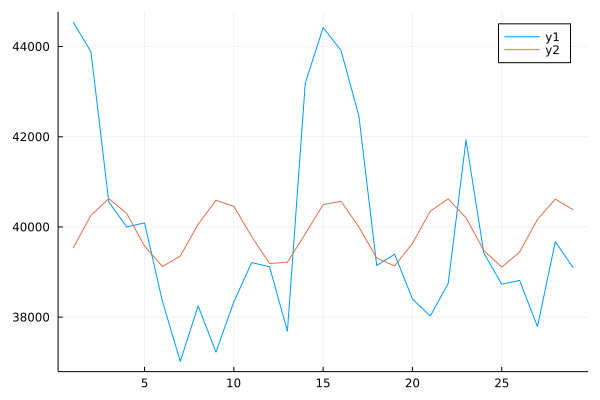

In [24]:
preds = xhs[1]*As[:,1] + xhs[2]*As[:,2] + xhs[3]*As[:,3]
plot(Array((1:29)), b)
plot!(Array((1:29)), preds)

Se podría mejorar el modelo anterior si se permite agregar variables $m$, $n$ para poder encontrar una función un poco más general: $f(x)=a\sin(mx)+b\cos(nx)+c$. En la siguiente tabla se presentan las predicciones y el porcentaje de error.

In [25]:
Predss = []
for i in 1:5
    append!(Predss,xhs[1]*sin(29+i) + xhs[2]*cos(29+i) + xhs[3])
end
Pt,Ht = readdlm("BitcoinToday.csv", ',', header=true);
dft = DataFrame(date = Pt[:,1], price = Pt[:,2]);
dft[:,2] = replace.(dft[:,2], "," => "");
dft[:,2] = parse.(Float64, dft[:,2]);
sort!(dft);
bt = Array(dft[:,2]);
difs = Predss-bt;
errs = map(x -> abs(x),difs);
errpors = []
for i in 1:5
    append!(errpors, errs[i]*100/bt[i])
end
DataFrame("Prediction" => Predss, "Bitcoin Price" => bt, "Difference" => difs, "Percent error" => errpors)

,Prediction,Bitcoin Price,Difference,Percent error
,Any,Any,Float64,Any
1,39672.3,41118.7,-1446.44,3.51772
2,39145.8,40914.8,-1768.96,4.32351
3,39284.1,41767.8,-2483.74,5.94655
4,39959.8,42233.0,-2273.18,5.38247
5,40551.8,41276.0,-724.154,1.75442


Con este modelo se obtiene el error porcentual promedio menor, en comparación con los obtenido con los modelos polinomiales.